2 [540, 180, 0, 540, 900, 900, 360, 360, 900, 540, 720]


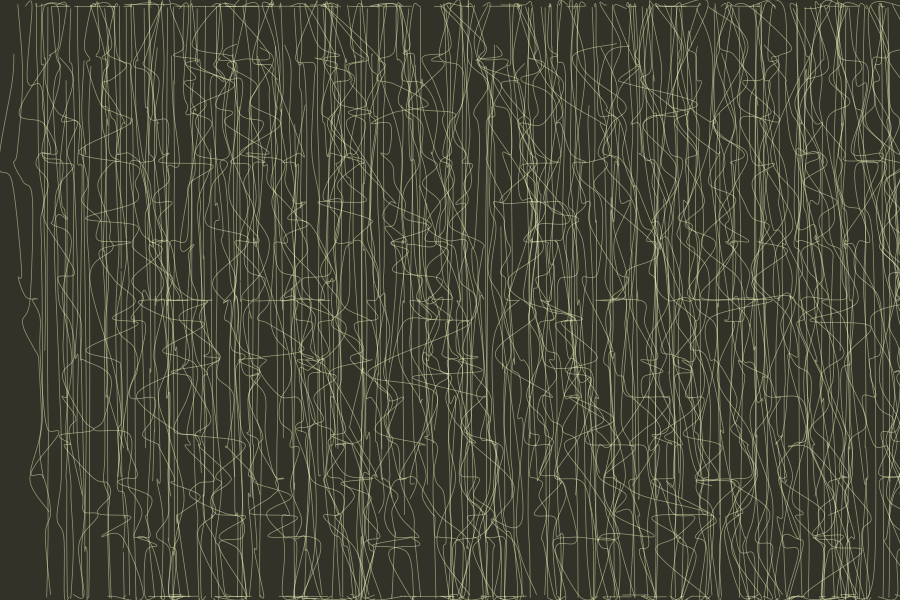

In [2]:
# WIP code refactoring

from py5canvas import *

import random
import numpy as np

create_canvas(900, 600)

background(50,50,40)
fill(250,255,200,125)
stroke(255,255,200,125)
stroke_weight(0.33)

# distance the vertical lines are apart
line_spacing = 22 

# initial pen position
x, y = 0, 0

# draws a curve connecting line points
def draw_line(x_bias, x_random, sum_lin):
    
    stroke_weight(0.75)
    no_fill() # stops lines being filled in as a shape
    begin_shape()
    for i in range(len(sum_lin)):
        curve_vertex(x + x_random[i] + x_bias[i], sum_lin[i] + y_offset) # <- tidy &/or calarify values used here 
    end_shape()

# 15:12:11:10:8 polyrhythm - alt. expanded values: [24,27,30,33,36,40,45], full scale cluster ratios 1 2 3 ^4 5 6 7
polyrhythm_nodes = [8,10,11,12,15] 

# initalise empty lists <- better in the calc_lines function?
line_calcs = []
summed_line = []

def calc_lines(): # <- separate into 2 functions calc and sum - better modularity - it's not crazily long, though
    global line_calcs, summed_line

    line_calcs = []
    summed_line = []

    for lin in range(int(width/line_spacing)):
        summed_line.append([]) # create new nested array for each line
        
        # calculate y values for each component pulse in the polyrhythm 
        for i in range(len(polyrhythm_nodes)):
            calc_y = 5
            line_calcs.append([])
            for j in range(polyrhythm_nodes[i]):
                line_calcs[i].append(calc_y)
                calc_y += int((height-10)/polyrhythm_nodes[i])
                # print(calc_y)

        # sum calculated line nodes (todo: sum rhythms/patterns expressed via x vals) into 1 line
        for i in range(len(polyrhythm_nodes)):
            for j in range(polyrhythm_nodes[i]):
            # 1/3 chance that a pulse is selected for use per component pulse - random pattern generation
                node_select = np.random.normal(1.167,1.167) # resolution of polyrhthm - was random.uniform(0,2.33)
                # print(node_select) 
                node_chance = micro_node_density(draw_pass,x) + macro_node_density(draw_pass)
                if node_select < node_chance: 
                    summed_line[lin].append(line_calcs[i][j])

            if node_select < node_chance: 
                summed_line[lin].append(height-5)   

        summed_line[lin].sort() # not necessary, but good for readability 

# vv better initialised inside function?
macro_pos = 0
micro_pos = []
# determine which pass of the canvas to centre macro dynamic peak on
def dynamic_form(passes): 
    divisions = [0,1,2,3,4,5] # positions along the duration of the score (no. passes) the macro peak can occur

    macro_pos = int((passes/5) * random_choice(divisions)) # gives which pass to centre gaussian dynamic peak on

    for p in range(passes): # do for each pass
        micro_pos.append(int((width/5) * random.choice(divisions)))

    print(macro_pos, micro_pos)
            
    return [macro_pos, micro_pos] 

# calculate gaussian field centred on determined x position per pass
def gaussian_field(current_pos, centre, range):
    return np.exp(-((current_pos - centre)**2) / (2 * range**2)) 

# include default values that prevent lines from being dead straight - if gaussian_weight < 0.1(for e.g.): x & node = default vals
# also use dynamics to change bias (drift) of lines?


# -- dynamic variations across all passes of the canvas -- 

def macro_x_variation(draw_pass):
    x_var_loc = 0
    x_var_scale = 0

    centre = macro_pos
    sigma = 2
    gaussian_weight = gaussian_field(draw_pass, centre, sigma)
    
    # prevent lines from becoming totally straight/nodeless by keeping gaussian_weight away from ~0.0
    if gaussian_weight < 0.075:
        gaussian_weight = 0.075

    x_var_loc = abs(gaussian_weight * np.random.normal(3, 2)) # 11,6
    x_var_scale = abs(gaussian_weight * np.random.normal(5, 4)) # 19,12

    # print(x_var_loc, x_var_scale)

    return [x_var_loc, x_var_scale]

def macro_line_drift(draw_pass):
    x_bias_loc = 0
    x_bias_scale = 0

    dec_line_spacing = 0

    # dynamically decrease line_spacing along with increased drift

    centre = macro_pos
    sigma = 2
    gaussian_weight = gaussian_field(draw_pass, centre, sigma)
    
    # prevent lines from becoming totally straight/nodeless by keeping gaussian_weight away from ~0.0
    if gaussian_weight < 0.075:
        gaussian_weight = 0.075

    x_bias_loc = abs(gaussian_weight * np.random.normal(1.5, 1)) 
    x_bias_scale = abs(gaussian_weight * np.random.normal(2, 1)) 

    dec_line_spacing = abs(gaussian_weight * np.random.normal(5.5, 2)) # at highest dynamics no. to detract from line_spacing

    return [x_bias_loc, x_bias_scale, dec_line_spacing]

def macro_node_density(draw_pass):
    node_density = 0.0

    centre = macro_pos
    sigma = 2 # width of gaussian bell curve applied to passes of canvas (effect either side of centre pass)
    gaussian_weight = gaussian_field(draw_pass, centre, sigma)
    # print(gaussian_weight)
    
    if gaussian_weight < 0.075:
        gaussian_weight = 0.075

    node_density = abs(gaussian_weight * np.random.normal(0.5,0.33)) # 0.5,0.33

    return node_density


#  -- dynamic variations per individual pass of the canvas --

def micro_x_variation(draw_pass, current_x):
    x_var_loc = 7
    x_var_scale = 12

    centre = micro_pos[draw_pass - 1]
    sigma = width/5 # gaussian apllication of dynamics  either side of centre x value per pass
    gaussian_weight = gaussian_field(current_x, centre, sigma)

    if gaussian_weight < 0.05:
        gaussian_weight = 0.05

    x_var_loc = abs(gaussian_weight * np.random.normal(7,5)) # 13,10
    x_var_scale = abs(gaussian_weight * np.random.normal(9,7)) # 19,15

    return [x_var_loc, x_var_scale]

def micro_line_drift(draw_pass, current_x):
    x_bias_loc = 0.75
    x_bias_scale = 1.5

    dec_line_spacing = 0

    centre = micro_pos[draw_pass - 1]
    sigma = width/5
    gaussian_weight = gaussian_field(current_x, centre, sigma)

    if gaussian_weight < 0.05:
        gaussian_weight = 0.05

    x_bias_loc = abs(gaussian_weight * np.random.normal(2,4))
    x_bias_scale = abs(gaussian_weight * np.random.normal(4,3))

    dec_line_spacing = abs(gaussian_weight * np.random.normal(5.5, 2))

    return [x_bias_loc, x_bias_scale, dec_line_spacing]

def micro_node_density(draw_pass, current_x):
    node_density = 1.0
        
    centre = micro_pos[draw_pass - 1]
    sigma = width/5
    gaussian_weight = gaussian_field(current_x, centre, sigma)

    if gaussian_weight < 0.05:
        gaussian_weight = 0.05
    
    node_density = abs(gaussian_weight * np.random.normal(1.5, 0.5)) # 1.5, 0.5

    # print(node_density)

    return node_density

y_offset = 0
# draw polyrhythm nodes to connect lines between
def draw_nodes(): # <- refactor into smaller functions?
    global x, line_spacing

    # r_val = 170
    # g_val = 186
    # b_val = 80
    # alpha_val = 155

    # macro_bias_space = macro_line_drift(draw_pass)[2]

    # line_spacing = int(22 - macro_bias_space) # add init_line_spacing variable?

    for lin in range(int(width/line_spacing)):
        # line-node variation
        x_random = []

        # line-node drift
        x_bias = []
        bias_random = 0 
        micro_bias_space = micro_line_drift(draw_pass,x)[2]

        line_spacing = int(22 - micro_bias_space) # add init_line_spacing variable?

        # print(line_spacing)

        for i in range(len(summed_line[lin])):
            # stroke(r_val, g_val, 80, alpha_val)

            # only call macro once outside of loop, then call once here? - not needed, calling mult times won't regenerate peak
            x_var_loc = micro_x_variation(draw_pass,x)[0] + macro_x_variation(draw_pass)[0]
            x_var_scale = micro_x_variation(draw_pass,x)[1] + macro_x_variation(draw_pass)[1]

            x_bias_loc = micro_line_drift(draw_pass,x)[0] + macro_line_drift(draw_pass)[0]
            x_bias_scale = micro_line_drift(draw_pass,x)[1] + macro_line_drift(draw_pass)[1]
            # make more efficient by only calling functions once? (store returned vals in arrays?)

            # print(x_var_loc, x_var_scale)

            x_random.append(np.random.normal(x_var_loc, x_var_scale)) 
            # generate randomised x vals, the same for each circle and equiv line bend and store in list

            bias_random += np.random.normal(x_bias_loc, x_bias_scale)
            x_bias.append(x + bias_random) # try to give lines trajectory towards to the right as the line progressses
            
            stroke_weight(1)
            # fill(r_val, g_val, b_val, alpha_val)
            # circle(x + x_random[i] + x_bias[i], summed_line[lin][i] + y_offset, np.random.normal(1,0.5))
            # r_val -= 0.1
            # g_val += 0.02
            # b_val += 0.2
            # alpha_val -= 0.05
            # print(r_val, g_val, b_val, alpha_val)

        draw_line(x_bias, x_random, summed_line[lin])
        # store all x values for a line to be called at once in the draw_line() loop per line

        # move to the right
        x += line_spacing

num_passes = 11
draw_pass = 0
def draw_passes():
    global x, y_offset, draw_pass, alpha_val

    x_init = 5
    x_offset = 0

    x = x_init

    dynamic_form(num_passes)
    
    while draw_pass < num_passes: # higher than division of ~line_spacing to cause overlap
        calc_lines()

        # alpha_val -= 5
        draw_nodes()
        #draw_text()
        # save(f'images/per_pass_score/07_score_pass_24_polyrhythm_{draw_pass}.png') # save image for each pass
        
        draw_pass += 1
        x_offset += (line_spacing*1.104)/7 # adding some interesting displacement in overlap
        y_offset += random.uniform(-1, 3) # np.random.normal(1,2)
        x = x_init + x_offset

        # print(f"pass made {draw_pass}")

# save('images/no_dotes_sparse_131115.png')
    
draw_passes()

show()